In [91]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.12.1+cu116


In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [4]:
df = pd.read_csv("customer_phone_contracts_2.csv")

In [5]:
df.head()

,customer_id,item_id,contract_start_date,contract_end_date,item_name,item_release_year,manufacturer,camera,height,width,weight,num_sim_cards,gps,touchscreen,color,memory
0,1,4759,2018-10-17,2020-03-18,Galaxy S22,2022,Samsung,12,5,3,185,1,1,1,Blue,64
1,1,9410,2020-05-07,2021-06-06,Pixel 9,2024,Google,12,7,3,182,2,0,0,Pink,512
2,1,9214,2021-07-13,2023-05-06,Mi 14,2024,Xiaomi,16,6,2,171,1,0,0,Purple,512
3,2,8160,2018-07-01,2020-02-22,Galaxy S24,2024,Samsung,16,6,2,226,2,0,1,Red,256
4,2,8160,2020-05-19,2021-09-14,Galaxy S24,2024,Samsung,16,6,2,226,2,0,1,Red,256


Class counts:
0       221
1       116
2        90
3        92
4       603
       ... 
558      91
559    1583
560     302
561     117
562      85
Name: item_id, Length: 563, dtype: int64


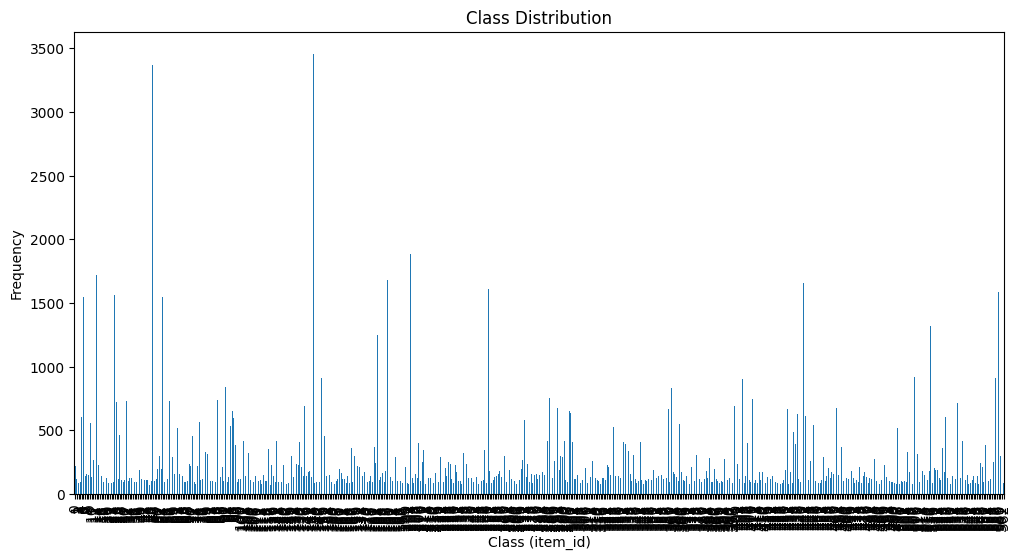

In [23]:
class_counts = df['item_id'].value_counts().sort_index()

print("Class counts:")
print(class_counts)

# Visualizing Class Distribution
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (item_id)')
plt.ylabel('Frequency')
plt.show()

In [6]:
label_encoders = {}
for column in ['manufacturer', 'color']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le


df['gps'] = df['gps'].astype(int)
df['touchscreen'] = df['touchscreen'].astype(int)
df['camera'] = df['camera'].astype(float)

df.fillna(0, inplace=True)

features = ['manufacturer', 'color', 'camera', 'height', 'width', 'weight', 'num_sim_cards', 'gps', 'touchscreen', 'memory']

target_encoder = LabelEncoder()
df['item_id'] = target_encoder.fit_transform(df['item_id'])
target = 'item_id'

df = df.sort_values(by='contract_start_date')
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])

grouped = df.groupby('customer_id')

train_data = []
val_data = []
test_data = []

for customer_id, group in grouped:
    group = group.sort_values('contract_start_date')
    if len(group) >= 3:
        test_data.append(group.iloc[-1])
        val_data.append(group.iloc[-2])
        train_data.extend(group.iloc[:-2].to_dict('records'))
    elif len(group) == 2:
        test_data.append(group.iloc[-1])
        val_data.append(group.iloc[-2])
    else:
        train_data.extend(group.to_dict('records'))


In [7]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [8]:
train_df.head(5)
val_df.head(5)
#test_df.head(20)

,customer_id,item_id,contract_start_date,contract_end_date,item_name,item_release_year,manufacturer,camera,height,width,weight,num_sim_cards,gps,touchscreen,color,memory
1,1,527,2020-05-07,2021-06-06,Pixel 9,2024,1,12.0,7,3,182,2,0,0,5,512
3,2,461,2018-07-01,2020-02-22,Galaxy S24,2024,7,16.0,6,2,226,2,0,1,7,256
5,3,297,2018-01-12,2019-08-12,Moto G9,2021,4,12.0,7,2,152,2,0,0,6,64
8,4,159,2019-11-28,2021-02-24,Mate 40,2020,2,16.0,6,2,188,1,0,1,8,64
10,5,421,2018-11-28,2020-10-21,Mate 50,2022,2,8.0,5,3,226,1,0,1,8,256


In [9]:
def split_data_balanced(df, test_customer_fraction=0.02, val_customer_fraction=0.08):
    unique_customers = df['customer_id'].unique()
    
    num_test_customers = int(len(unique_customers) * test_customer_fraction)
    num_val_customers = int(len(unique_customers) * val_customer_fraction)
    
    test_customers = np.random.choice(unique_customers, num_test_customers, replace=False)
    remaining_customers = np.setdiff1d(unique_customers, test_customers)
    val_customers = np.random.choice(remaining_customers, num_val_customers, replace=False)
    train_customers = np.setdiff1d(remaining_customers, val_customers)
    
    train_df = df[df['customer_id'].isin(train_customers)]
    val_df = df[df['customer_id'].isin(val_customers)]
    test_df = df[df['customer_id'].isin(test_customers)]
    
    return train_df, val_df, test_df


train_df, val_df, test_df = split_data_balanced(df)

print("Training DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print("Test DataFrame shape:", test_df.shape)


Training DataFrame shape: (121070, 16)
Validation DataFrame shape: (10767, 16)
Test DataFrame shape: (2706, 16)


In [10]:
def create_sequences(dataframe):
    grouped = dataframe.groupby('customer_id')
    sequences = []
    labels = []

    for customer_id, group in grouped:
        group = group.sort_values('contract_start_date')
        if len(group) > 1:
            for i in range(1, len(group)):
                sequences.append(group[features].iloc[:i].values.astype(np.float32))
                labels.append(group[target].iloc[i])

    if not sequences:
        raise ValueError("No sequences found in the DataFrame")

    max_seq_length = max(len(seq) for seq in sequences)
    padded_sequences = [np.pad(seq, ((0, max_seq_length - len(seq)), (0, 0)), 'constant') for seq in sequences]

    X = torch.tensor(np.array(padded_sequences), dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.long)

    return X, y

In [ ]:
X_train, y_train = create_sequences(train_df)
X_val, y_val = create_sequences(val_df)
X_test, y_test = create_sequences(test_df)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [92]:
batch_size = 64

In [93]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [99]:
input_size = len(features)
hidden_size = 128
num_layers = 3
output_size = len(target_encoder.classes_)

dropout = 0.2
lr=0.001
weight_decay=1e-4

best_val_loss = float('inf')
patience = 5
trigger_times = 0
num_epochs = 500

In [80]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.elu = nn.ELU()
        self.fc = nn.Linear(hidden_size, output_size)

        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.batch_norm(out[:, -1, :])
        out = self.layer_norm(out)
        out = self.elu(out)
        out = self.fc(out)
        return out

In [95]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.batch_norm(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [96]:
class_weights = compute_class_weight('balanced', classes=np.unique(df['item_id']), y=df['item_id'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [100]:
model = GRUModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [101]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    torch.cuda.empty_cache()  # Clear GPU memory
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    scheduler.step()
    
    print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1, Train Loss: 5.5493, Val Loss: 5.3207, Val Accuracy: 0.0570
Epoch 2, Train Loss: 5.2475, Val Loss: 5.3330, Val Accuracy: 0.0584
Epoch 3, Train Loss: 5.1467, Val Loss: 5.1687, Val Accuracy: 0.0678
Epoch 4, Train Loss: 5.0662, Val Loss: 5.0937, Val Accuracy: 0.0839
Epoch 5, Train Loss: 5.0014, Val Loss: 5.1211, Val Accuracy: 0.0860
Epoch 6, Train Loss: 4.9454, Val Loss: 5.0745, Val Accuracy: 0.0986
Epoch 7, Train Loss: 4.8913, Val Loss: 5.0684, Val Accuracy: 0.1021
Epoch 8, Train Loss: 4.8534, Val Loss: 5.0492, Val Accuracy: 0.1098
Epoch 9, Train Loss: 4.8194, Val Loss: 4.9575, Val Accuracy: 0.1182
Epoch 10, Train Loss: 4.7980, Val Loss: 4.9916, Val Accuracy: 0.1133
Epoch 11, Train Loss: 4.7932, Val Loss: 4.9797, Val Accuracy: 0.1162
Epoch 12, Train Loss: 4.7959, Val Loss: 4.9921, Val Accuracy: 0.1163
Epoch 13, Train Loss: 4.8042, Val Loss: 4.9774, Val Accuracy: 0.1203
Epoch 14, Train Loss: 4.8102, Val Loss: 4.9853, Val Accuracy: 0.1150
Epoch 15, Train Loss: 4.8150, Val Loss: 4.9

KeyboardInterrupt: 

In [115]:
torch.save(model.state_dict(), 'GRU_500_epochs.pth')

In [60]:
model.load_state_dict(torch.load('GRU_500_epochs.pth'))

<All keys matched successfully>

In [116]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

Test Loss: 1.6853, Test Accuracy: 0.4924


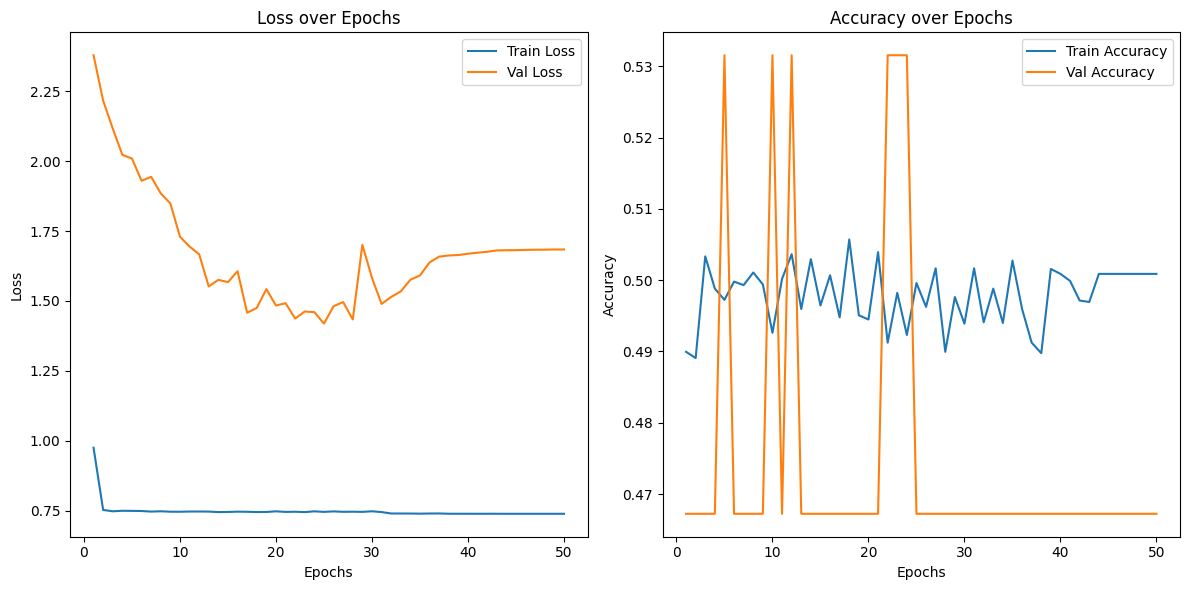

In [117]:
test_losses = []
test_accuracies = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_test += targets.size(0)
        correct_test += (predicted == targets).sum().item()

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct_test / total_test
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')



epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()